In [15]:
import numpy as np

import os
import json
import glob
# import subprocess
from pprint import pprint

import pandas as pd
import numpy as np
# from scipy import signal
import cv2
# from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Conv2D  # , Dense
from tensorflow.keras.initializers import Initializer
from tensorflow.keras.datasets import cifar10
from tensorflow.python.framework import dtypes
from tensorflow.keras.utils import to_categorical
# from K.tensorflow_backend import set_session
# from K.tensorflow_backend import clear_session
# from K.tensorflow_backend import get_session
from sklearn.metrics import auc
from scipy.integrate import simps

# Needed for load_images
from tqdm import tqdm
from matplotlib import pyplot as plt
params = {
        'DoG': {
            'ksize': (15,15),
            'sigmas': [1, 2, 4],
            'gammas': [1.6, 1.8, 2, 2.2]
            },
        'Gabor': {
            'ksize': (7, 7),
            'sigmas': [4],
            'gammas': [0.5], 
            'bs': np.linspace(1, 2.6, num=3).tolist(),
            'thetas': np.linspace(0, np.pi, 4, endpoint=False).tolist(),
            'psis': [np.pi/2, 3*np.pi/2]
            },
    'Gabor2': {
            'ksize': (7, 7),
            'sigmas': [4],
            'gammas': [0.5], 
            'bs': np.linspace(1, 2.6, num=3).tolist(),
            'thetas': np.linspace(0, np.pi, 4, endpoint=False).tolist(),
            'psis': [np.pi/2, 3*np.pi/2]
            },
}
class GaborInitializer(Initializer):
    """Gabor kernel initializer class."""

    def __init__(self, ksize, sigmas, bs, gammas, thetas, psis, verbose=0):
        # TODO: Deprecate ksize in (initialisation of) filter parameters
        if isinstance(ksize, (int, float)):
            self.ksize = (ksize, ksize)
        else:
            self.ksize = tuple(ksize)
#     def __init__(self, sigmas, bs, gammas, thetas, psis, verbose=0):
        self.sigmas = sigmas
        self.bs = bs
        self.gammas = gammas
        self.thetas = thetas
        self.psis = psis
        self.n_kernels = len(sigmas) * len(bs) * len(gammas) * len(thetas) * len(psis)
        self.verbose = verbose

    # TODO: Use @property decorator with setter and getter methods
    # def calc_n_kernels(params):
    #     return len(params['bs']) * len(params['sigmas']) * len(params['thetas']) \
    #                              * len(params['gammas']) * len(params['psis'])

    def __call__(self, shape, dtype=None):
        """Returns a tensor object initialized as specified by the initializer.
        Args:
            shape: Shape of the tensor.
            dtype: Optional dtype of the tensor. If not provided use the initializer
            dtype.
            partition_info: Optional information about the possible partitioning of a
            tensor.
        """
        # return get_gabor_tensor(ksize, bs, sigmas, thetas, gammas, psis, lambdas=None)
        # return get_gabor_tensor(**self.params)
        if self.verbose:
            print(f"Shape passed to GaborInitializer: {shape}")
        if shape is None:
            ksize = self.ksize
            n_channels_in = 1  # Assume monochrome inputs
            n_channels_out = self.n_kernels
        else:
            ksize = tuple(shape[:2])
            n_channels_in = shape[2]
            n_channels_out = shape[-1]
            assert self.ksize == ksize, f"[ksize] Passed: {ksize}; Expected: {self.ksize}"
            assert self.n_kernels == n_channels_out, f"[n_kernels] Passed: {n_channels_out}; Expected: {self.n_kernels}"
        # print(f'{ksize=}')
        # return get_gabor_tensor(ksize, self.bs, self.sigmas, 
        #                         self.thetas, self.gammas, self.psis, self.verbose)

        gabors = []
        for sigma in self.sigmas:
            for theta in self.thetas:
                # for lambd in lambdas:
                for b in self.bs:
                    lambd = calc_lambda(sigma, b)
                    for gamma in self.gammas:
                        for psi in self.psis:
                            gf = cv2.getGaborKernel(ksize, sigma, theta, 
                                                    lambd, gamma, psi, 
                                                    # ktype=cv2.CV_32F)
                                                    ktype=cv2.CV_64F)
                            gf = K.expand_dims(gf, -1)
                            gf = K.tile(gf, (1, 1, n_channels_in))  # Generalise for multi-channel inputs
                            gabors.append(gf)
        assert len(gabors) == self.n_kernels
        if self.verbose:
            print(f"Created {self.n_kernels} kernels.")
            if self.verbose > 1:
                print("bs:", self.bs)
                print("sigmas:", self.sigmas)
                print("thetas:", self.thetas)
                print("gammas:", self.gammas)
                print("psis:", self.psis)

        # print(gf.get_shape())
        gf_tensor = K.stack(gabors, axis=-1)  # (ksize[0], ksize[1], 1, n_kernels)
        if dtype:
            assert dtype in ('float16', 'float32', 'float64')
            if self.verbose:
                print(f"Casting to {dtype}")
        else:
            dtype = 'float32'
        gf_tensor = K.cast(gf_tensor, dtype)  # tf.keras.backend.cast
        if self.verbose:
            print(f"Generated tensor shape: {gf_tensor.get_shape()}")
        return gf_tensor

    def get_config(self):
        """Returns the configuration of the initializer as a JSON-serializable dict.
        Returns:
        A JSON-serializable Python dict.
        """
        # return {"dtype": self.dtype.name ...}
        # return self.params
        return {'ksize': self.ksize,
                'sigmas': self.sigmas,
                'bs': self.bs,
                'gammas': self.gammas,
                'thetas': self.thetas,
                'psis': self.psis
                }
def calc_bandwidth(lambd, sigma):
    r = np.pi*sigma/lambd
    c = np.sqrt(np.log(2)/2)
    return np.log2((r + c)/(r - c))

def calc_sigma(lambd, bandwidth):
    p = 2**bandwidth
    c = np.sqrt(np.log(2)/2)
    return lambd * c / np.pi  * (p + 1) / (p - 1)

def calc_lambda(sigma, bandwidth):
    p = 2**bandwidth
    c = np.sqrt(np.log(2)/2)
    return sigma * np.pi / c  * (p - 1) / (p + 1)


def get_gabor_tensor(ksize, bs, sigmas, thetas, gammas, psis, lambdas=None, verbose=0):
    """Create a tensor of Gabor filters for greyscale images.
    
    The sinusoidal wavelength $\lambda$ is constrained by the bandwidth $b$
    and Gaussian spatial scale $\sigma$.
    """

    # n_kernels = len(sigmas) * len(thetas) * len(lambdas) * len(gammas) * len(psis)
    n_kernels = len(bs) * len(sigmas) * len(thetas) * len(gammas) * len(psis)
    gabors = []
    for sigma in sigmas:
        for theta in thetas:
            # for lambd in lambdas:
            for b in bs:
                lambd = calc_lambda(sigma, b)
                for gamma in gammas:
                    for psi in psis:
                        # params = {'ksize': ksize, 'sigma': sigma,
                        #           'theta': theta, 'lambd': lambd,
                        #           'gamma': gamma, 'psi': psi}
                        # gf = cv2.getGaborKernel(**params, ktype=cv2.CV_32F)
                        gf = cv2.getGaborKernel(ksize, sigma, theta, 
                                                lambd, gamma, psi, 
                                                ktype=cv2.CV_32F)
                        gf = K.expand_dims(gf, -1)
                        gabors.append(gf)
    assert len(gabors) == n_kernels
    if verbose:
        print(f"Created {n_kernels} kernels.")
        if verbose > 1:
            print("bs:", bs)
            print("sigmas:", sigmas)
            print("thetas:", thetas)
            print("gammas:", gammas)
            print("psis:", psis)
    return K.stack(gabors, axis=-1)  # (ksize[0], ksize[1], 1, n_kernels)


@tf.function
def convolve_tensor(x, kernel_tensor=None):
    '''
    conv2d
    input tensor: [batch, in_height, in_width, in_channels]
    kernel tensor: [filter_height, filter_width, in_channels, out_channels]
    '''
    # x = tf.image.rgb_to_grayscale(x)
    # print(f"Input shape: {x.shape}")
    # print(f"Kernel tensor shape: {kernel_tensor.shape}")  # TODO: Should this be (127, 127, 3, n)?

    # NOTE: This function does not apply bias or pass through an activation function
    # TODO: Do I need to add bias and pass through an activation function before returning? Maybe...
    return K.conv2d(x, kernel_tensor, padding='same')


def find_conv_layer(model, first=True):
    if first:
        layers = model.layers
    else:
        layers = reversed(model.layers)
    for ind, layer in enumerate(layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
        # if len(layer.output_shape) == 4:
            print(f"Found first convolutional layer {ind}: {layer.name}")
            layer_name = layer.name
            layer_ind = ind
            break
    return layer_name, layer_ind



In [13]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def ResNet50(input_shape=(224, 224, 1)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(24, (7, 7), strides=(2, 2), name='conv1', kernel_initializer= GaborInitializer(params['Gabor']['ksize'], params['Gabor']['sigmas'],params['Gabor']['bs'], params['Gabor']['gammas'],params['Gabor']['thetas'], params['Gabor']['psis']))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [21]:
base_model = ResNet50(input_shape=(224, 224, 1))
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 100,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

In [32]:
import pickle
import numpy as np
with open('/home/maria/Documents/CommunicationSubspaces/data_dictV3.pickle', 'rb') as handle:
        dat = pickle.load(handle)
X_train=dat['X_train'][:,:,90:180,:]
x_train=tf.image.resize(tf.convert_to_tensor(X_train), size=(224, 224))
print(x_train.shape)
y_train=dat['y_train']

(4436, 224, 224, 1)


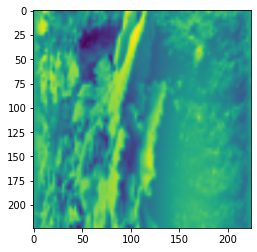

In [33]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0,:,:,0])

In [34]:
model = Model(inputs=base_model.input, outputs=headModel)
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
# Compile the model
model.compile(loss='mse', optimizer=opt, metrics=['cosine_similarity'])

In [ ]:
history = model.fit(x_train, dat['y_train'], batch_size=100, epochs=500, validation_split=0.2)

Epoch 1/500
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
